# Compare
- BPR: Bayesian Personalized Ranking from Implicit Feedback
https://arxiv.org/abs/1205.2618
- WSABIE: Scaling Up To Large Vocabulary Image Annotation http://www.thespermwhale.com/jaseweston/papers/wsabie-ijcai.pdf
- Learning to Rank Recommendations with the k-Order Statistic Loss https://research.google.com/pubs/pub41534.html

### Data
- Movielens 100k https://grouplens.org/datasets/movielens/100k/
- README - http://files.grouplens.org/datasets/movielens/ml-100k-README.txt

In [1]:
import os
import pandas as pd
from scipy.sparse import coo_matrix, csr_matrix, diags
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import log_loss, accuracy_score, roc_curve, roc_auc_score
from sklearn.utils.extmath import safe_sparse_dot
import time
import math

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from warp import WARPNaive, KosWARP
from bpr import BPR 

In [4]:
dtype = np.float32

In [5]:
data_dir = "/Users/timwee/projects/datasets/movielens/ml-100k"

def load_data_from_f(fpath):
    # columns - user id | item id | rating | timestamp
    # user_id and item_id numbered consecutively from 1
    with open(fpath) as f:
        users, items, ratings = [], [], []
        max_user = -1
        max_item = -1
        for line in f:
            user_id, item_id, rating, ts = [int(tok) for tok in line.strip().split("\t")]
            # make it zero indexed
            user_id -= 1
            item_id -= 1
            max_user = max(max_user, user_id)
            max_item = max(max_item, item_id)
            users.append(user_id) 
            items.append(item_id)
            ratings.append(rating)
        return np.array(users), np.array(items), np.array(ratings), max_user, max_item


def train_and_test_data(data_dir, train_fname="ua.base", test_fname="ua.test", dtype=np.float32):
    trn_u, trn_i, trn_r, max_trn_u, max_trn_i = load_data_from_f(os.path.join(data_dir, train_fname))
    tst_u, tst_i, tst_r, max_tst_u, max_tst_i = load_data_from_f(os.path.join(data_dir, test_fname))
    num_rows = max(max_trn_u, max_tst_u) + 1
    num_cols = max(max_trn_i, max_tst_i) + 1
    return {"train" : coo_matrix((trn_r, (trn_u, trn_i)), shape=(num_rows, num_cols), dtype=dtype).tocsr(), \
            "test" : coo_matrix((tst_r, (tst_u, tst_i)), shape=(num_rows, num_cols), dtype=dtype).tocsr()}
    

In [6]:
movielens = train_and_test_data(data_dir, dtype=dtype)
train, test = movielens["train"], movielens["test"]
num_users, num_items = train.shape
train.shape, test.shape

((943, 1682), (943, 1682))

### learning rate decay

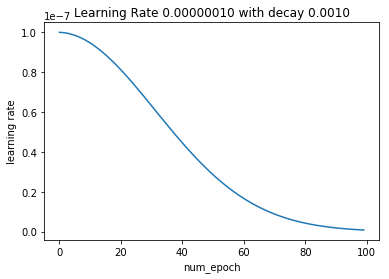

In [7]:
lrate = 1e-7
decay = 1e-3
lr_val = [lrate]
for i in range(1, 100):
    lr_val.append(lr_val[i-1] * (1. / (1. + (decay * i))))
plt.plot(np.arange(100), lr_val)
plt.xlabel("num_epoch")
plt.ylabel("learning rate")
plt.title("Learning Rate %.8f with decay %.4f" % (lrate, decay))
plt.show()

## helpers

In [8]:
def plot_auc(title, auc_scores, num_epochs):
    epoch_x = np.arange(num_epochs)
    test_line, = plt.plot(epoch_x, auc_scores, label="auc test")
    plt.legend([test_line], ["test auc"])
    plt.xlabel("num_epoch")
    plt.ylabel("auc_score")
    plt.title(title)
    plt.show()

In [9]:
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k, reciprocal_rank

/Users/timwee/anaconda3/lib/python3.5/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


# WARP class

In [10]:
durations = []
tst_warp_auc = []
tst_warp_prec5 = []
tst_warp_rr = []

model = WARPNaive(lr=5e-7, item_reg=0.2, user_reg=0.2)
num_epochs = 70
for epoch in range(num_epochs):
    start = time.time()
    model.fit(train, reset=False)
    duration = time.time() - start
    durations.append(duration)    
    tst_auc = auc_score(model, test, train_interactions=train).mean()
    tst_prec5 = precision_at_k(model, test, train_interactions=train, k=5).mean()
    tst_rr = reciprocal_rank(model, test, train_interactions=train).mean()
    tst_warp_auc.append(tst_auc)
    tst_warp_prec5.append(tst_prec5)
    tst_warp_rr.append(tst_rr)
    print("warp iteration %d took %.4f, auc: %.4f, p@5: %.4f, rr: %.4f" % \
          (epoch, duration, tst_auc, tst_prec5, tst_rr))

initializing embeddings and biases
warp iteration 0 took 5.0769, auc: 0.6232, p@5: 0.0303, rr: 0.0966
warp iteration 1 took 5.0446, auc: 0.6688, p@5: 0.0333, rr: 0.1010
warp iteration 2 took 5.0646, auc: 0.6956, p@5: 0.0335, rr: 0.1047
warp iteration 3 took 5.0750, auc: 0.7140, p@5: 0.0350, rr: 0.1099
warp iteration 4 took 5.2123, auc: 0.7275, p@5: 0.0363, rr: 0.1169
warp iteration 5 took 5.0903, auc: 0.7372, p@5: 0.0375, rr: 0.1216
warp iteration 6 took 5.1183, auc: 0.7447, p@5: 0.0378, rr: 0.1264
warp iteration 7 took 5.0739, auc: 0.7509, p@5: 0.0373, rr: 0.1330
warp iteration 8 took 5.0439, auc: 0.7558, p@5: 0.0378, rr: 0.1353
warp iteration 9 took 5.1254, auc: 0.7604, p@5: 0.0380, rr: 0.1374
warp iteration 10 took 5.1453, auc: 0.7642, p@5: 0.0386, rr: 0.1386
warp iteration 11 took 5.0886, auc: 0.7674, p@5: 0.0384, rr: 0.1418
warp iteration 12 took 5.2168, auc: 0.7702, p@5: 0.0392, rr: 0.1463
warp iteration 13 took 5.0663, auc: 0.7725, p@5: 0.0399, rr: 0.1463
warp iteration 14 took 

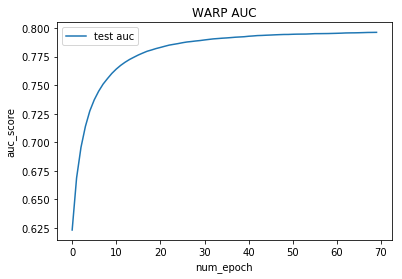

In [ ]:
plot_auc("WARP AUC", tst_warp_auc, num_epochs)

## BPR Class

In [ ]:
durations = []
tst_bpr_auc = []
tst_bpr_prec5 = []
tst_bpr_rr = []

bpr_model = BPR(lr=5e-7, item_reg=0.2, user_reg=0.2)
num_epochs = 70
for epoch in range(num_epochs):
    start = time.time()
    bpr_model.fit(train, reset=False)
    duration = time.time() - start
    durations.append(duration)    
    tst_auc = auc_score(bpr_model, test, train_interactions=train).mean()
    tst_prec5 = precision_at_k(bpr_model, test, train_interactions=train, k=5).mean()
    tst_rr = reciprocal_rank(bpr_model, test, train_interactions=train).mean()
    tst_bpr_auc.append(tst_auc)
    tst_bpr_prec5.append(tst_prec5)
    tst_bpr_rr.append(tst_rr)
    print("iteration %d took %.4f, auc: %.4f, p@5: %.4f, rr: %.4f" % (epoch, duration, tst_auc, tst_prec5, tst_rr))

initializing embeddings and biases
iteration 0 took 5.4555, auc: 0.5129, p@5: 0.0068, rr: 0.0359
iteration 1 took 5.4719, auc: 0.5276, p@5: 0.0089, rr: 0.0430
iteration 2 took 5.5093, auc: 0.5414, p@5: 0.0142, rr: 0.0532
iteration 3 took 5.5413, auc: 0.5540, p@5: 0.0155, rr: 0.0644
iteration 4 took 5.4852, auc: 0.5651, p@5: 0.0165, rr: 0.0719
iteration 5 took 5.5214, auc: 0.5752, p@5: 0.0206, rr: 0.0782
iteration 6 took 5.5513, auc: 0.5844, p@5: 0.0214, rr: 0.0814
iteration 7 took 5.5676, auc: 0.5928, p@5: 0.0221, rr: 0.0835
iteration 8 took 5.5557, auc: 0.6007, p@5: 0.0242, rr: 0.0863
iteration 9 took 5.5212, auc: 0.6079, p@5: 0.0235, rr: 0.0885
iteration 10 took 5.5259, auc: 0.6147, p@5: 0.0244, rr: 0.0900
iteration 11 took 5.5211, auc: 0.6212, p@5: 0.0255, rr: 0.0918
iteration 12 took 5.5782, auc: 0.6272, p@5: 0.0265, rr: 0.0939
iteration 13 took 5.4980, auc: 0.6329, p@5: 0.0274, rr: 0.0940
iteration 14 took 5.5125, auc: 0.6383, p@5: 0.0282, rr: 0.0939
iteration 15 took 5.7706, auc:

In [ ]:
reciprocal_rank(bpr_model, test, train_interactions=train).mean()

In [ ]:
plot_auc("BPR AUC", tst_bpr_auc, len(tst_bpr_auc))

# KOS Warp

In [ ]:
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k

durations = []
tst_koswarp_auc = []
tst_koswarp_prec5 = []
tst_koswarp_rr = []

kos_model = KosWARP(lr=5e-7, item_reg=0.2, user_reg=0.2)
num_epochs = 70
for epoch in range(num_epochs):
    start = time.time()
    kos_model.fit(train, reset=False)
    duration = time.time() - start
    durations.append(duration)    
    tst_auc = auc_score(kos_model, test, train_interactions=train).mean()
    tst_prec5 = precision_at_k(kos_model, test, train_interactions=train, k=5).mean()
    tst_rr = reciprocal_rank(kos_model, test, train_interactions=train).mean()
    tst_koswarp_auc.append(tst_auc)
    tst_koswarp_prec5.append(tst_prec5)
    tst_koswarp_rr.append(tst_rr)
    print("iteration %d took %.4f, auc: %.4f, p@5: %.4f, rr: %.4f" % \
          (epoch, duration, tst_auc, tst_prec5, tst_rr))

In [ ]:
plot_auc("KOS WARP AUC", tst_koswarp_auc, len(tst_koswarp_auc))